In [6]:
# impotamos librerias a utilizar
import numpy as np
import matplotlib.pyplot as plt
import torch
import scipy.io as sio
import random

In [14]:
# Cargar el archivo MAT
emnist_digits = sio.loadmat('emnist-digits.mat')

In [26]:
# cargamos las caracteristicas de emnist de entrenamiento
X_train = emnist_digits["dataset"]["train"][0][0]["images"][0][0]
print("Shape X_train: ", X_train.shape)
# cargamos las etiquetas de emnist de entrenamiento
y_train = emnist_digits["dataset"]["train"][0][0]["labels"][0][0]
print("Shape y_train: ", y_train.shape)

# cargamos las caracteristicas de emnist de prueba
X_test = emnist_digits["dataset"]["test"][0][0]["images"][0][0]
print("Shape X_test: ", X_test.shape)
# cargamos las etiquetas de emnist de prueba
y_test = emnist_digits["dataset"]["test"][0][0]["labels"][0][0]
print("Shape y_test: ", y_test.shape)

Shape X_train:  (240000, 784)
Shape y_train:  (240000, 1)
Shape X_test:  (40000, 784)
Shape y_test:  (40000, 1)


In [29]:
X_train.dtype, y_train.dtype

(dtype('uint8'), dtype('int32'))

In [28]:
y_train = y_train.astype(np.int32)

In [30]:
# mostramos las clases
print('y_train clases: ', np.unique(y_train))
print('y_test clases: ', np.unique(y_test))

y_train clases:  [0 1 2 3 4 5 6 7 8 9]
y_test clases:  [0 1 2 3 4 5 6 7 8 9]


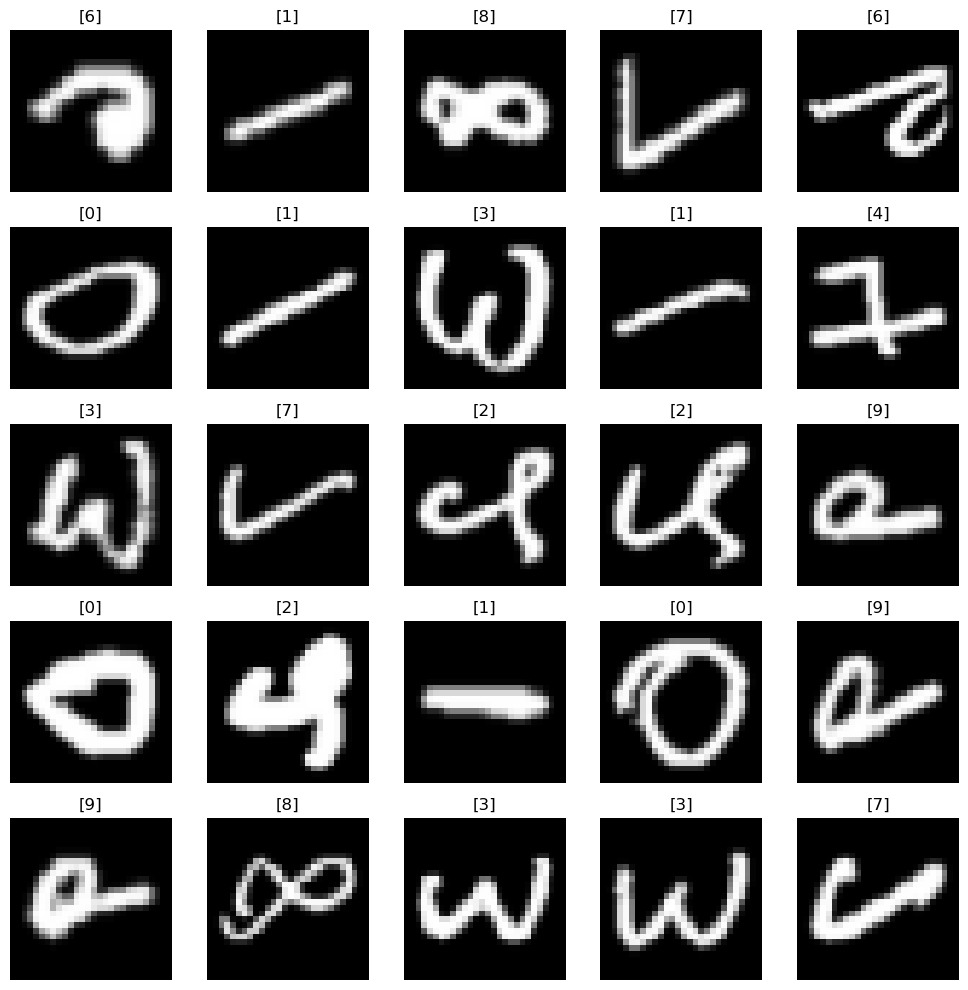

In [31]:
r, c = 5, 5
fig = plt.figure(figsize=(2*c, 2*r))
for _r in range(r):
    for _c in range(c):
        plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(X_train)-1)
        img = X_train[ix]
        plt.imshow(img.reshape(28,28), cmap='gray')
        plt.axis("off")
        plt.title(y_train[ix])
plt.tight_layout()
plt.show()

In [32]:

def build_model(D_in=28*28, H=100, D_out=10):
    return torch.nn.Sequential(
        torch.nn.Linear(D_in, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, D_out)
    ).cuda()

In [34]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = torch.from_numpy(X / 255.).float().cuda().view(-1, 28*28)
        self.Y = torch.from_numpy(Y).long().cuda()
    def __len__(self):
        return len(self.X)
    def __getitem__(self, ix):
        return self.X[ix], self.Y[ix]

In [60]:
# fit de un batch
dataset = Dataset(X_train, y_train.squeeze())
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

len(dataset)

240000

In [61]:

def calculate_accuracy(model, dataloader):
    correct = 0
    total = 0

    with torch.no_grad():
        for x_b, y_b in dataloader:
            y_pred = model(x_b)
            _, predicted = torch.max(y_pred.data, 1)
            total += y_b.size(0)
            correct += (predicted == y_b).sum().item()

    accuracy = correct / total
    return accuracy

# Ejemplo de uso
epochs = 100
criterion = torch.nn.CrossEntropyLoss()
model = build_model()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

loss_values = []
accuracy_values = []

for e in range(1, epochs + 1):
    for x_b, y_b in dataloader:
        y_pred = model(x_b)
        loss = criterion(y_pred, y_b)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if not e % 10:
        accuracy = calculate_accuracy(model, dataloader)
        print(f"Epoch {e}/{epochs} loss {loss.item():.5f} accuracy {accuracy:.4f}")
        
    loss_values.append(loss.item())
    accuracy_values.append(accuracy)

Epoch 10/100 loss 0.00075 accuracy 0.9954
Epoch 20/100 loss 0.00073 accuracy 0.9963
Epoch 30/100 loss 0.00000 accuracy 0.9978
Epoch 40/100 loss 0.00050 accuracy 0.9980
Epoch 50/100 loss 0.00703 accuracy 0.9989
Epoch 60/100 loss 0.00000 accuracy 0.9982
Epoch 70/100 loss 0.00012 accuracy 0.9984
Epoch 80/100 loss 0.00359 accuracy 0.9984
Epoch 90/100 loss 0.00000 accuracy 0.9992
Epoch 100/100 loss 0.00000 accuracy 0.9994


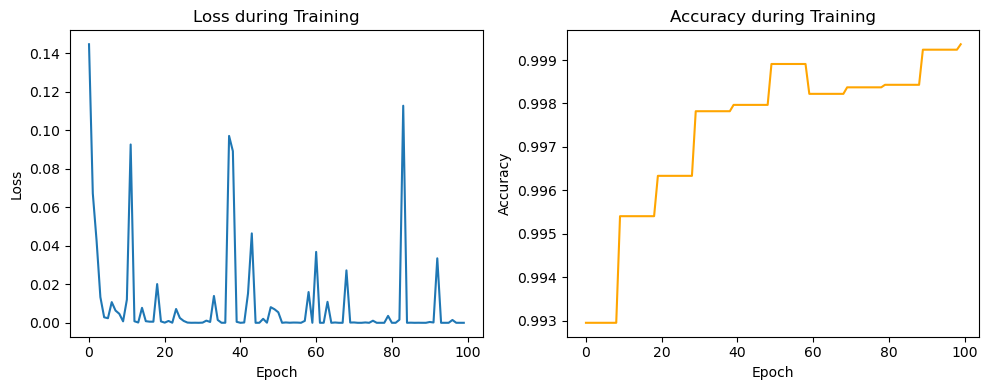

In [62]:
def plot_loss_and_accuracy(loss_values, accuracy_values):
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(loss_values)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss during Training')

    plt.subplot(1, 2, 2)
    plt.plot(accuracy_values, color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy during Training')

    plt.tight_layout()
    plt.show()

# Llamamos a la función para dibujar
plot_loss_and_accuracy(loss_values, accuracy_values)

In [63]:
# Guardar el estado del modelo
torch.save(model.state_dict(), 'modelo_entrenado.pth')